In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import torchmetrics
import torch.nn as nn

In [2]:
class ConvAttMLP_10layers_add(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0 = nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 1100)
        self.fc11=nn.Linear(1100,1100)
        self.bn1 = nn.BatchNorm1d(1100)
        self.fc2 = nn.Linear(2200, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, 9)
        self.bn3 = nn.BatchNorm1d(9)

        self.drop = nn.Dropout(0.5)
        
        
        # Conv layers
        self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        self.conv2 = nn.Conv1d(8, 16, 5, padding=2)
        self.conv3 = nn.Conv1d(16, 16, 5, padding=2)  # Change to match input channel 16
        self.conv4 = nn.Conv1d(16, 1, 1, stride=1)
        #self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        self.bn4 = nn.BatchNorm1d(3300)
        #self.conv2 = nn.Conv1d(8, 16, 5, padding=2)
        self.bn5 = nn.BatchNorm1d(3300)
        self.pool2 = nn.MaxPool1d(3, stride=3)
        #self.conv3 = nn.Conv1d(16, 1, 1, stride=1)
        self.pool3 = nn.MaxPool1d(3, stride=3)
        self.bn6 = nn.BatchNorm1d(1100)
        
        self.bn7=nn.BatchNorm1d(2200)

        self.avg_pool = nn.AvgPool1d(kernel_size=3300)
        self.max_pool = nn.MaxPool1d(kernel_size=3300)
        self.fc = nn.Sequential(
            nn.Conv1d(16, 16 // 8, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(16 // 8, 16, 1, padding=0, bias=False),
            nn.Sigmoid()
        )

        # Define a list to hold multiple layers
        self.layers = nn.ModuleList([self._create_layer() for _ in range(2)])

    def _create_layer(self):
        """Create a single layer using conv and pooling operations as defined in the original forward method."""
        return nn.Sequential(
            nn.Conv1d(1, 8, 5, padding=2),
            nn.BatchNorm1d(3300),
            nn.Conv1d(8, 16, 5, padding=2),
            nn.Conv1d(16, 16, 5, padding=2),  # Match input/output channel
            nn.Conv1d(16, 1, 1, stride=1),  # This will receive 16 channels and output 1
            nn.AvgPool1d(kernel_size=3300),
            nn.MaxPool1d(kernel_size=3300)
        )

    def forward(self, x):
        x = self.bn0(x)
        x1= F.relu(self.drop(self.bn1(self.fc11(self.fc1(x)))))
        
        
        x0 = torch.unsqueeze(x, 1)  # Add a channel dimension
        #print('x0:',x0.shape)
        # Pass through each layer sequentially
        for layer in self.layers:
            
            x2 = F.relu(layer[0](x0))  # Conv1
            x2 = F.relu(layer[2](x2))  # Conv2
            avg_pool = self.avg_pool(x2)
            avg_out = self.fc(self.avg_pool(x2))
            max_pool = self.max_pool(x2)
            max_out = self.fc(self.max_pool(x2))
            out = avg_out + max_out
            x2 = torch.mul(x2, out)
            x2 = F.relu(layer[4](x2))  # Conv3
            x2 = x0 + x2  # Skip connection
            x0 = x2  # Pass to next layer
            #print('x0+++:',x0.shape)
            
        x2=self.pool3(x2)
        #print('x2:',x2.shape)
        x2=torch.squeeze(x2,1)
        x2=self.bn6(x2)
        #x3=torch.add(x1,x2)
        #x3=torch.concat([x1,x2],dim=1)
        #print('x2_final:',x2.shape)
        #x3=torch.add(x1,x2)
        x3=torch.cat([x1,x2],dim=1)
        x4=self.bn7(x3)
        x4 = F.relu(self.drop(self.bn2(self.fc2(x4))))
        return F.softmax(self.bn3(self.fc3(x4)), dim=1) 
    
modela=ConvAttMLP_10layers_add()
modela.cuda()
print(modela)    

ConvAttMLP_10layers_add(
  (bn0): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3300, out_features=1100, bias=True)
  (fc11): Linear(in_features=1100, out_features=1100, bias=True)
  (bn1): BatchNorm1d(1100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2200, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (conv1): Conv1d(1, 8, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2): Conv1d(8, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv4): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
  (bn4): BatchNorm1d(3300, eps=1e-05, momentum=0.1, affin

In [5]:
class ConvAttMLP_10layers_add_LRP(nn.Module):
    def __init__(self):
        super().__init__()
        #self.bn0 = nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 1100)
        self.fc11=nn.Linear(1100,1100)
        #self.bn1 = nn.BatchNorm1d(1100)
        #self.fc2 = nn.Linear(2200, 100)
        self.fc22=nn.Linear(1100,100)
        #self.bn2 = nn.BatchNorm1d(100)
        self.fc3 = nn.Linear(100, 9)
        #self.bn3 = nn.BatchNorm1d(9)

        self.drop = nn.Dropout(0.5)
        
        
        # Conv layers
        #self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        #self.conv2 = nn.Conv1d(8, 16, 5, padding=2)
        #self.conv3 = nn.Conv1d(16, 16, 5, padding=2)  # Change to match input channel 16
        #self.conv4 = nn.Conv1d(16, 1, 1, stride=1)
        #self.conv1 = nn.Conv1d(1, 8, 5, padding=2)
        #self.bn4 = nn.BatchNorm1d(3300)
        #self.conv2 = nn.Conv1d(8, 16, 5, padding=2)
        #self.bn5 = nn.BatchNorm1d(3300)
        #self.pool2 = nn.MaxPool1d(3, stride=3)
        #self.conv3 = nn.Conv1d(16, 1, 1, stride=1)
        #self.pool3 = nn.MaxPool1d(3, stride=3)
        #self.bn6 = nn.BatchNorm1d(1100)
        
        #self.bn7=nn.BatchNorm1d(2200)
        '''
        self.avg_pool = nn.AvgPool1d(kernel_size=3300)
        self.max_pool = nn.MaxPool1d(kernel_size=3300)
        self.fc = nn.Sequential(
            nn.Conv1d(16, 16 // 8, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.Conv1d(16 // 8, 16, 1, padding=0, bias=False),
            nn.Sigmoid()
        )
        
        # Define a list to hold multiple layers
        self.layers = nn.ModuleList([self._create_layer() for _ in range(2)])
        '''
        
    ''' 
    def _create_layer(self):
        """Create a single layer using conv and pooling operations as defined in the original forward method."""
        return nn.Sequential(
            nn.Conv1d(1, 8, 5, padding=2),
            nn.BatchNorm1d(3300),
            nn.Conv1d(8, 16, 5, padding=2),
            nn.Conv1d(16, 16, 5, padding=2),  # Match input/output channel
            nn.Conv1d(16, 1, 1, stride=1),  # This will receive 16 channels and output 1
            nn.AvgPool1d(kernel_size=3300),
            nn.MaxPool1d(kernel_size=3300)
        )
    '''
    def forward(self, x):
        print('x:',x.shape)
        #x2=x[0,3300:]
        #x = self.bn0(x)
        #print('x_bn0:',x.shape)
        #x2=torch.zeros([1,1100])
        #x2=x2.cuda()
        #xm=torch.cat([x,x2],dim=1)
        
        #print('xm.shape:',xm.shape)
        x1= F.relu(self.drop(self.fc11(self.fc1(x))))
        
        """
        x0 = torch.unsqueeze(x, 1)  # Add a channel dimension
        #print('x0:',x0.shape)
        # Pass through each layer sequentially
        for layer in self.layers:
            ）
            x2 = F.relu(layer[0](x0))  # Conv1
            x2 = F.relu(layer[2](x2))  # Conv2
            avg_pool = self.avg_pool(x2)
            avg_out = self.fc(self.avg_pool(x2))
            max_pool = self.max_pool(x2)
            max_out = self.fc(self.max_pool(x2))
            out = avg_out + max_out
            x2 = torch.mul(x2, out)
            x2 = F.relu(layer[4](x2))  # Conv3
            x2 = x0 + x2  # Skip connection
            x0 = x2  # Pass to next layer
            #print('x0+++:',x0.shape)
            
        x2=self.pool3(x2)
        #print('x2:',x2.shape)
        x2=torch.squeeze(x2,1)
        x2=self.bn6(x2)
        #x3=torch.add(x1,x2)
        #x3=torch.concat([x1,x2],dim=1)
        #print('x2_final:',x2.shape)
        #x3=torch.add(x1,x2)
        """
        #print('x1.device:',x1.device)
        #x2=torch.zeros([1,1100])
        #x2=x2.cuda()
        #print('x2.device:',x2.device)
        #print('x1.shape:',x1.shape)
        #print('x2.shape:',x2.shape)
        #x2=torch.squeeze(x2,0)
        #print('x2.shape:',x2.shape)
        #x3=torch.cat([x1,x2],dim=-1)
        #print('x3.shape:',x3.shape)
        #x4=self.bn7(x3)
        x4 = F.relu(self.drop(self.fc22(x1)))
        return F.softmax(self.fc3(x4), dim=-1) 
    
modela=ConvAttMLP_10layers_add_LRP()
modela.cuda()
print(modela)    

ConvAttMLP_10layers_add_LRP(
  (fc1): Linear(in_features=3300, out_features=1100, bias=True)
  (fc11): Linear(in_features=1100, out_features=1100, bias=True)
  (fc22): Linear(in_features=1100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (drop): Dropout(p=0.5, inplace=False)
)


In [12]:
import torch
#import Trainer
#from network import NFM
import torch.utils.data as Data
#from Utils.criteo_loader import getTestData, getTrainData
from torch.nn import functional as F
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
#import torchmetrics
nfm_config = \
{
    'n_class':9,
    'linear_hidden1':2000,
    #'linear_hidden':100,#线性模型输出层（隐层个数）
    #'embed_input_dim':1001,#embed输入维度
    #'embed_dim': 100, # 用于控制稀疏特征经过Embedding层后的稠密特征大小，embed输出维度
    #'dnn_hidden_units': [100,11],#MLP隐层和输出层
    
    'dnn_hidden_units':[100,9],#MLP隐层
    'num_sparse_features_cols':10477,#the number of the gene columns
    'num_dense_features': 0,#dense features number
    'bi_dropout': 0.5,#Bi-Interaction 的dropout
    'num_epoch': 500,#训练epoch次数
    'batch_size': 16,#batch_size
    'lr': 1e-3,
    'l2_regularization': 1e-4,
    'device_id': 0,
    'use_cuda': False,
    'epoch':1000,
    
    #'train_file': '../Data/criteo/processed_data/train_set.csv',
    #'fea_file': '../Data/criteo/processed_data/fea_col.npy',
    #'validate_file': '../Data/criteo/processed_data/val_set.csv',
    #'test_file': '../Data/criteo/processed_data/test_set.csv',
    #'model_name': '../TrainedModels/NFM.model'
    #'train_file':'data/xiaoqiu_gene_5000/train/final_5000_encode_100x.csv',
    #'train_data':'dataset/qiuguan/encode/encode_1000/train/train_encode_data_1000_new.csv',
    #'train_label':'dataset/qiuguan/non_code/train/train_label.csv',
    #'guan_test_data':'dataset/qiuguan/non_code/guan_test/guan_test_data.csv',
    #'guan_test_label':'dataset/qiuguan/non_code/guan_test/guan_test_label.csv',
    #'test_data':'dataset/qiuguan/encode/encode_1000/test/test_encode_data_1000_new.csv',
    #'test_label':'dataset/qiuguan/non_code/test/test_labels.csv',
    #'title':'dataset/xiaoguan/RF/RF_for_train/train_class_9/test/test_data.csv',
    
    #'all':''
    #'title':'data/xiaoqiu_gene_5000/train/gene_5000_gene_name.csv',
    #'all':'data/xiaoqiu_gene_5000/train/gene_5000_label_name.csv'
}

#model definition
import torch.nn as nn
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(3300)
        self.fc1 = nn.Linear(3300, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model = MLP().cuda()
#print(model)

class MLP20(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(56)
        self.fc1 = nn.Linear(56, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model20 = MLP20().cuda()



class MLP1(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(237)
        self.fc1 = nn.Linear(237, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model1 = MLP1().cuda()
print(model1)
class MLP2(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(126)
        self.fc1 = nn.Linear(126, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model2 = MLP2().cuda()
#print(model2)


class MLP3(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(177)
        self.fc1 = nn.Linear(177, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model3 = MLP3().cuda()
#print(model3)

class MLP4(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(130)
        self.fc1 = nn.Linear(130, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model4 = MLP4().cuda()

class MLP5(nn.Module):
    def __init__(self):
        super().__init__()
        self.bn0=nn.BatchNorm1d(172)
        self.fc1 = nn.Linear(172, 2000)
        self.bn1= nn.BatchNorm1d(2000)
        self.fc2 = nn.Linear(2000, 100)
        self.bn2=nn.BatchNorm1d(100)
        self.fc3=nn.Linear(100,9)
        self.bn3=nn.BatchNorm1d(9)
        
        self.drop=nn.Dropout(0.5)
    def forward(self, x):
        x=self.bn0(x)
        x = F.relu(self.drop(self.bn1(self.fc1(x))))
        x = F.relu(self.drop(self.bn2(self.fc2(x))))
        return F.softmax(self.bn3(self.fc3(x)), dim=1)
model5 = MLP5().cuda()
import time

import torch
import torch.nn as nn
from torch.nn import functional as F







#print(model4)
import os
import time
import argparse
import numpy as np
import pandas as pd 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.backends.cudnn as cudnn
#3from tensorboardX import SummaryWriter
import torch.nn.functional as F  # 激励函数的库
#import network
#import config
#import evaluate
#import data_utils
#import Trainer



def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    #n = len(labels)
    n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output

def one_hot(labels, classes):
    n = len(labels)
    #eoff = label_smoothing / classes
    output = np.zeros((n, classes), dtype=np.float32)
    for row, label in enumerate(labels):
        output[row, label] = 1
        #print("row:",row,"label:",label)
    return output


def one_hot_smoothing(labels, classes, label_smoothing=0.2):
    #n = len(labels)
    n=labels.shape[0]
    eoff = label_smoothing / classes
    output = np.ones((n, classes), dtype=np.float32) * eoff
    for row, label in enumerate(labels):
        output[row, label] = 1 - label_smoothing + eoff
        #print("row:",row,"label:",label)
    return output

def one_hot(labels, classes):
    n = len(labels)
    #eoff = label_smoothing / classes
    output = np.zeros((n, classes), dtype=np.float32)
    for row, label in enumerate(labels):
        output[row, label] = 1
        #print("row:",row,"label:",label)
    return output



class KZDatasetPredict(data.Dataset):
    """ Construct the FM pytorch dataset. """
    #def __init__(self, file,label_file, feature_map,n_class=16):
    def __init__(self, df_list):
    
       
        self.data_info = self.get_data_info(df_list)
        
        
            
        
        
        

    def __getitem__(self, index):
        # Dataset读取图片的函数
        data,label = self.data_info[index]
        #img = Image.open(img_pth).convert('RGB')
        
        return data,label

    def __len__(self):
        return len(self.data_info)
   
    
    
    def get_data_info(self,df_list):
        #解析路径
        #转为一维list存储，每一位为【图片路径，图片类别】
        labels=[]
        data_info=[]
        #print('data_info:',df_list[-1])
        #df=pd.read_csv(csv_path,sep=',')
        #df=df.iloc[:,1:]
        
        #print(df.iloc[:,-1])
        #df=df.applymap(ast.literal_eval)
        label=int(df_list[-1])
        labels.append(label)
        #print('labels:',labels)
        data=df_list[:-1]
        #df_np=np.array(df_list)
        #print(rows,cols)
        
        #print('labels:',labels)
        labels=np.array(labels)
        #print('labels.shape:',labels.shape)
        #print('labels:',labels)
        #labels=np.array(labels)
        labels=one_hot_smoothing(labels,nfm_config['n_class'])
        #print(labels)
        
           
        
        data=np.array(data)#
            
            
            
            
            
            
            
            
        data=torch.from_numpy(data)#
            
        labels=torch.from_numpy(labels)#
        #bi_data=embding_process(nfm_config,data)
        #print("bi_data.shape:",bi_data.shape)
            
            
        data_info.append((data,label))
        return data_info
class KZDatasetTest(data.Dataset):
    """ Construct the FM pytorch dataset. """
    #def __init__(self, file,label_file, feature_map,n_class=16):
    def __init__(self, csv_path):
    
       
        self.data_info = self.get_data_info(csv_path)
        
        
            
        
        
        

    def __getitem__(self, index):
        # Dataset读取图片的函数
        data, label = self.data_info[index]
        #img = Image.open(img_pth).convert('RGB')
        
        return data, label

    def __len__(self):
        return len(self.data_info)
   
    
    
    def get_data_info(self,csv_path):
        #解析路径
        #转为一维list存储，每一位为【图片路径，图片类别】
        labels=[]
        data_info=[]
        df=pd.read_csv(csv_path,sep=',')
        df=df.iloc[:,1:]
        
        #print(df.iloc[:,-1])
        #df=df.applymap(ast.literal_eval)
        rows,cols=df.shape
        print(rows,cols)
        for i in df.iloc[:,-1]:
            #print(i)
            labels.append(int(i))
        #print('labels:',labels)
        labels=np.array(labels)
        #print('labels:',labels)
        #labels=np.array(labels)
        labels=one_hot_smoothing(labels,nfm_config['n_class'])
        #print(labels)
        for i in range(rows):
            data=df.iloc[i,:-1]
            data=data.astype(float)#
            data=np.array(data)#
            
            label=labels[i]
            #print(data.shape)
            #print(label.shape)
            #label=label.tolist()
            data=torch.from_numpy(data)#
            label=torch.from_numpy(label)#
            
            
            data_info.append((data,label))
        return data_info
import torch
import torch.nn as nn
from torch.utils.data.dataset import *
from PIL import Image
from torch.nn import functional as F
import random
from sklearn.model_selection import train_test_split
import ast
import torchvision


        

class KZDataset(Dataset):
    def __init__(self, csv_path, K,n_class,ki=0, typ='train', transform=None, rand=False):
       
        self.all_data_info = self.get_data_info(csv_path)
        
        if rand:
            random.seed(1)
            random.shuffle(self.all_data_info)
        leng = len(self.all_data_info)
        every_z_len = leng // K
        if typ == 'val':
            self.data_info = self.all_data_info[every_z_len * ki : every_z_len * (ki+1)]
        elif typ == 'train':
            self.data_info = self.all_data_info[: every_z_len * ki] + self.all_data_info[every_z_len * (ki+1) :]
            
        self.transform = transform
        
        

    def __getitem__(self, index):
        # Dataset读取图片的函数
        data, label = self.data_info[index]
        #img = Image.open(img_pth).convert('RGB')
        
        return data, label

    def __len__(self):
        return len(self.data_info)
    
    
    
    def get_data_info(self,csv_path):
        #解析路径
        #转为一维list存储，每一位为【图片路径，图片类别】
        labels=[]
        data_info=[]
        df=pd.read_csv(csv_path,sep=',')
        df=df.iloc[:,1:]
        
        #print(df.iloc[:,-1])
        #df=df.applymap(ast.literal_eval)
        rows,cols=df.shape
        
        print(rows,cols)
        for i in df.iloc[:,-1]:
            #print(i)
            labels.append(int(i))
        #print('labels:',labels)
        labels=np.array(labels)
        #print('labels:',labels)
        #labels=np.array(labels)
        labels=one_hot_smoothing(labels,nfm_config['n_class'])
        #print(labels)
        for i in range(rows):
            data=df.iloc[i,:-1]
            data=data.astype(float)#
            data=np.array(data)#
            
            label=labels[i]
            #print(data.shape)
            #print(label.shape)
            #label=label.tolist()
            data=torch.from_numpy(data)#
            label=torch.from_numpy(label)#
            
            
            data_info.append((data,label))
        return data_info
    
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
#from new_nfm_network import NFM
import os
import time
import argparse
import numpy as np
import pandas as pd 
import sys

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
#import torch.backends.cudnn as cudnn
#3from tensorboardX import SummaryWriter

#import torchmetrics
            

from torchmetrics.classification import accuracy

def train_epoch(model,train_loader,batch_size,optimizer,loss_func):
    BATCH_SIZE=batch_size
    total = 0
    correct=0
    total_loss=0
    #
    model.train()
    total_train_accuracy=0  
    for batch_idx, (x, labels) in enumerate(train_loader):
            
        labels = Variable(labels)
        x = Variable(x)
            
            
        x=torch.tensor(x,dtype=torch.float)
        labels=torch.tensor(labels,dtype=torch.float)
        x, labels = x.cuda(), labels.cuda()
        labels_int=labels=torch.max(labels,1)[1]
            
            
        optimizer.zero_grad()
        y_predict = model(x)
            
        loss = loss_func(y_predict, labels)
        loss.backward()
        optimizer.step()
            
        loss = loss.item()
           

        total_loss += loss
            
            
            
        #
        '''
        train_acc_en=torchmetrics.Accuracy(task='multiclass',num_classes=9).cuda()
        batch_train_acc=train_acc_en(y_predict,labels_int)
        '''
        #batch_train_acc=torchmetrics.functional.accuracy(y_predict,labels_int)
        #batch_train_acc=torchmetrics.classification.Accuracy(y_predict,labels_int)
        batch_train_acc = torchmetrics.functional.accuracy(y_predict, labels_int, task='multiclass', num_classes=nfm_config['n_class'])
        
        
        #train_acc_en=accuracy(y_predict,labels_int)
        #batch_train_acc=train_acc_en()
        
        total_train_accuracy+=batch_train_acc
            
    total_train_accuracy/=(batch_idx+1)
    print('total_train_accuracy:',total_train_accuracy)
    print("Training Epoch: %d, total loss: %f" % (epoch_id, total_loss))
    return total_loss,total_train_accuracy

def val_epoch(model,test_loader,batch_size,optimizer): 
    batch_size_num=0
    total_test_acc=0
    model.eval()
    for i , (inputs , targets) in enumerate(test_loader):   
            print("test")
            
            inputs = Variable(inputs)   
            targets = Variable(targets)     
           
            inputs=torch.tensor(inputs ,dtype=torch.float)   
            targets=torch.tensor(targets ,dtype=torch.float)   
            inputs , targets = inputs.cuda(),  targets.cuda()   
            yhat = model(inputs)  
            
            
            
            targets=torch.max(targets,1)[1]
            
            
            
            #test_acc_en=torchmetrics.Accuracy(task='multiclass',num_classes=9).cuda()
            #batch_test_acc=torchmetrics.functional.accuracy(yhat,targets)
            batch_test_acc = torchmetrics.functional.accuracy(yhat, targets, task='multiclass', num_classes=nfm_config['n_class'])
            total_test_acc+=batch_test_acc
            
            batch_size_num=i
    total_test_acc/=(batch_size_num+1)
        ###print('total_test_accuracy:',total_test_acc/(batch_size+1))
    print('total_test_accuracy:',total_test_acc)
        
                    
                    
            
            
    
        
   
    
    return total_test_acc


import numpy as np
import math
import matplotlib.pyplot as plt

def plotLoss(loss,epoch):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.figure(figsize=(8, 5))
    x=[i for i in range(epoch)]
    #acc_train=acc_train.cpu()
    #acc_test=acc_test.cpu()
    plt.plot(x, loss, 'r-', mec='k', label='Logistic Loss', lw=2)
    #plt.plot(x,acc_train,'b-',mec='k',label='accuracy Train',lw=2)
    #plt.plot(x,acc_test,'g-',mec='k',label='accuracy Test',lw=2)
    #plt.plot(x, y_01, 'g-', mec='k', label='0/1 Loss', lw=2)
    #plt.plot(x, y_hinge, 'b-',mec='k', label='Hinge Loss', lw=2)
    #plt.plot(x, boost, 'm--',mec='k', label='Adaboost Loss',lw=2)
    plt.grid(True, ls='--')
    plt.legend(loc='upper right')
    plt.title('损失函数')
    plt.show()
 


MLP1(
  (bn0): BatchNorm1d(237, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=237, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)


549 117
549 117


/tmp/ipykernel_19002/2313943418.py:518: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:519: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.1542, device='cuda:0')
Training Epoch: 0, total loss: 65.316275
total_train_accuracy: tensor(0.3021, device='cuda:0')
Training Epoch: 1, total loss: 63.421045
total_train_accuracy: tensor(0.3229, device='cuda:0')
Training Epoch: 2, total loss: 62.824015
total_train_accuracy: tensor(0.3833, device='cuda:0')
Training Epoch: 3, total loss: 62.080338
total_train_accuracy: tensor(0.3979, device='cuda:0')
Training Epoch: 4, total loss: 61.783336
total_train_accuracy: tensor(0.4375, device='cuda:0')
Training Epoch: 5, total loss: 61.294685
total_train_accuracy: tensor(0.4188, device='cuda:0')
Training Epoch: 6, total loss: 61.155184
total_train_accuracy: tensor(0.4604, device='cuda:0')
Training Epoch: 7, total loss: 60.511912
total_train_accuracy: tensor(0.4604, device='cuda:0')
Training Epoch: 8, total loss: 60.407134
total_train_accuracy: tensor(0.5208, device='cuda:0')
Training Epoch: 9, total loss: 59.484354
total_train_accuracy: tensor(0.5271, device='cuda:

total_train_accuracy: tensor(0.7271, device='cuda:0')
Training Epoch: 86, total loss: 51.214269
total_train_accuracy: tensor(0.7583, device='cuda:0')
Training Epoch: 87, total loss: 50.415459
total_train_accuracy: tensor(0.6979, device='cuda:0')
Training Epoch: 88, total loss: 51.723391
total_train_accuracy: tensor(0.7333, device='cuda:0')
Training Epoch: 89, total loss: 50.759028
total_train_accuracy: tensor(0.6917, device='cuda:0')
Training Epoch: 90, total loss: 52.270657
total_train_accuracy: tensor(0.7271, device='cuda:0')
Training Epoch: 91, total loss: 51.319232
total_train_accuracy: tensor(0.7250, device='cuda:0')
Training Epoch: 92, total loss: 51.293870
total_train_accuracy: tensor(0.7500, device='cuda:0')
Training Epoch: 93, total loss: 50.666321
total_train_accuracy: tensor(0.7417, device='cuda:0')
Training Epoch: 94, total loss: 50.767452
total_train_accuracy: tensor(0.7458, device='cuda:0')
Training Epoch: 95, total loss: 50.300628
total_train_accuracy: tensor(0.7229, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

total_train_accuracy: tensor(0.7292, device='cuda:0')
Training Epoch: 100, total loss: 51.338999
the  0  epoch ends


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

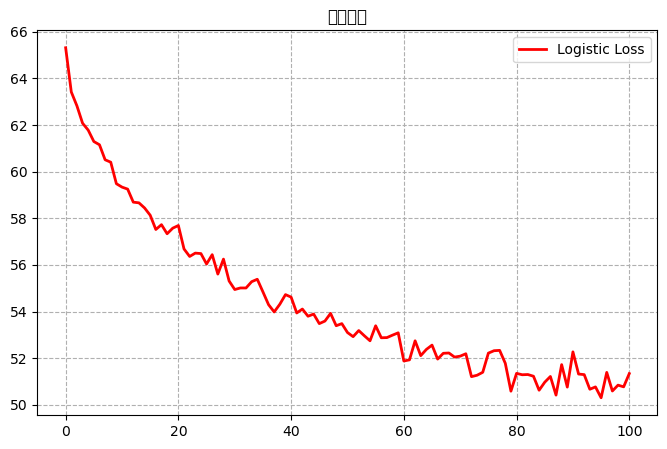

/tmp/ipykernel_19002/2313943418.py:568: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:569: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.6667, device='cuda:0')
acc_test_each_k: tensor(0.6667, device='cuda:0')
549 117
549 117
total_train_accuracy: tensor(0.7250, device='cuda:0')
Training Epoch: 0, total loss: 51.533382


/tmp/ipykernel_19002/2313943418.py:518: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:519: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.7125, device='cuda:0')
Training Epoch: 1, total loss: 50.981891
total_train_accuracy: tensor(0.7688, device='cuda:0')
Training Epoch: 2, total loss: 50.078073
total_train_accuracy: tensor(0.7250, device='cuda:0')
Training Epoch: 3, total loss: 50.964860
total_train_accuracy: tensor(0.7250, device='cuda:0')
Training Epoch: 4, total loss: 51.045438
total_train_accuracy: tensor(0.7458, device='cuda:0')
Training Epoch: 5, total loss: 50.402489
total_train_accuracy: tensor(0.7625, device='cuda:0')
Training Epoch: 6, total loss: 50.266437
total_train_accuracy: tensor(0.7375, device='cuda:0')
Training Epoch: 7, total loss: 50.507648
total_train_accuracy: tensor(0.7354, device='cuda:0')
Training Epoch: 8, total loss: 50.457043
total_train_accuracy: tensor(0.7542, device='cuda:0')
Training Epoch: 9, total loss: 49.962861
total_train_accuracy: tensor(0.7396, device='cuda:0')
Training Epoch: 10, total loss: 50.491056
total_train_accuracy: tensor(0.7375, device='cuda

total_train_accuracy: tensor(0.8146, device='cuda:0')
Training Epoch: 87, total loss: 47.943831
total_train_accuracy: tensor(0.8229, device='cuda:0')
Training Epoch: 88, total loss: 47.612599
total_train_accuracy: tensor(0.8021, device='cuda:0')
Training Epoch: 89, total loss: 48.489330
total_train_accuracy: tensor(0.7833, device='cuda:0')
Training Epoch: 90, total loss: 48.830264
total_train_accuracy: tensor(0.7938, device='cuda:0')
Training Epoch: 91, total loss: 48.697487
total_train_accuracy: tensor(0.7875, device='cuda:0')
Training Epoch: 92, total loss: 48.773031
total_train_accuracy: tensor(0.7521, device='cuda:0')
Training Epoch: 93, total loss: 49.569227
total_train_accuracy: tensor(0.7771, device='cuda:0')
Training Epoch: 94, total loss: 48.684044
total_train_accuracy: tensor(0.7917, device='cuda:0')
Training Epoch: 95, total loss: 48.494646
total_train_accuracy: tensor(0.7792, device='cuda:0')
Training Epoch: 96, total loss: 48.746606
total_train_accuracy: tensor(0.7938, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

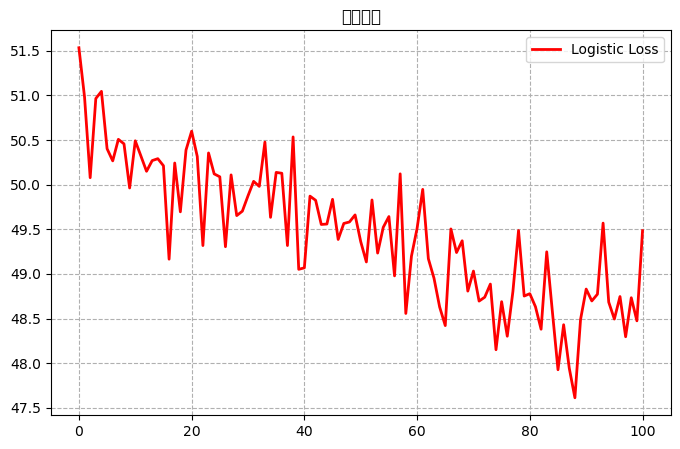

/tmp/ipykernel_19002/2313943418.py:568: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:569: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.7083, device='cuda:0')
acc_test_each_k: tensor(0.7083, device='cuda:0')
549 117
549 117
total_train_accuracy: tensor(0.7583, device='cuda:0')
Training Epoch: 0, total loss: 49.154966


/tmp/ipykernel_19002/2313943418.py:518: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:519: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.7542, device='cuda:0')
Training Epoch: 1, total loss: 49.323295
total_train_accuracy: tensor(0.7625, device='cuda:0')
Training Epoch: 2, total loss: 49.439381
total_train_accuracy: tensor(0.7750, device='cuda:0')
Training Epoch: 3, total loss: 48.715793
total_train_accuracy: tensor(0.7875, device='cuda:0')
Training Epoch: 4, total loss: 48.366007
total_train_accuracy: tensor(0.7542, device='cuda:0')
Training Epoch: 5, total loss: 49.423717
total_train_accuracy: tensor(0.7938, device='cuda:0')
Training Epoch: 6, total loss: 48.811507
total_train_accuracy: tensor(0.8021, device='cuda:0')
Training Epoch: 7, total loss: 48.428675
total_train_accuracy: tensor(0.7917, device='cuda:0')
Training Epoch: 8, total loss: 48.695805
total_train_accuracy: tensor(0.8083, device='cuda:0')
Training Epoch: 9, total loss: 48.169142
total_train_accuracy: tensor(0.7875, device='cuda:0')
Training Epoch: 10, total loss: 48.636250
total_train_accuracy: tensor(0.8167, device='cuda

total_train_accuracy: tensor(0.8333, device='cuda:0')
Training Epoch: 87, total loss: 47.005075
total_train_accuracy: tensor(0.8125, device='cuda:0')
Training Epoch: 88, total loss: 47.698728
total_train_accuracy: tensor(0.7854, device='cuda:0')
Training Epoch: 89, total loss: 48.384743
total_train_accuracy: tensor(0.8333, device='cuda:0')
Training Epoch: 90, total loss: 47.476274
total_train_accuracy: tensor(0.8229, device='cuda:0')
Training Epoch: 91, total loss: 47.490870
total_train_accuracy: tensor(0.8313, device='cuda:0')
Training Epoch: 92, total loss: 47.295710
total_train_accuracy: tensor(0.8125, device='cuda:0')
Training Epoch: 93, total loss: 47.619017
total_train_accuracy: tensor(0.8313, device='cuda:0')
Training Epoch: 94, total loss: 47.201703
total_train_accuracy: tensor(0.8521, device='cuda:0')
Training Epoch: 95, total loss: 46.673948
total_train_accuracy: tensor(0.8458, device='cuda:0')
Training Epoch: 96, total loss: 46.963341
total_train_accuracy: tensor(0.8271, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/

total_train_accuracy: tensor(0.8375, device='cuda:0')
Training Epoch: 100, total loss: 46.978038
the  2  epoch ends


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

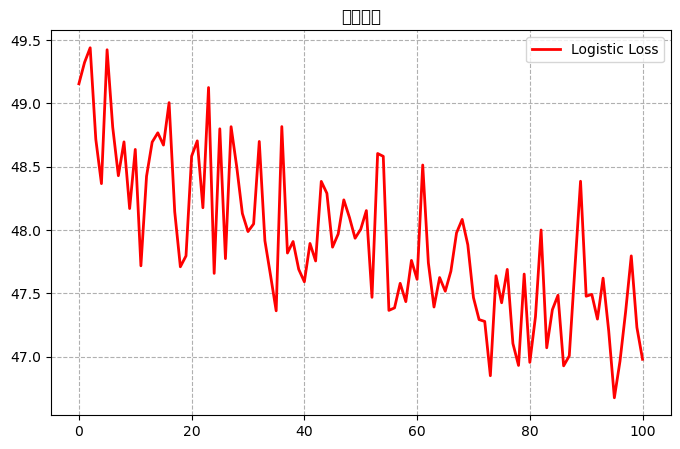

/tmp/ipykernel_19002/2313943418.py:568: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:569: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.8958, device='cuda:0')
acc_test_each_k: tensor(0.8958, device='cuda:0')
549 117
549 117
total_train_accuracy: tensor(0.8354, device='cuda:0')
Training Epoch: 0, total loss: 47.049492


/tmp/ipykernel_19002/2313943418.py:518: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:519: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.8188, device='cuda:0')
Training Epoch: 1, total loss: 47.486055
total_train_accuracy: tensor(0.7896, device='cuda:0')
Training Epoch: 2, total loss: 47.965171
total_train_accuracy: tensor(0.8146, device='cuda:0')
Training Epoch: 3, total loss: 47.708213
total_train_accuracy: tensor(0.8333, device='cuda:0')
Training Epoch: 4, total loss: 47.283789
total_train_accuracy: tensor(0.8125, device='cuda:0')
Training Epoch: 5, total loss: 47.961950
total_train_accuracy: tensor(0.8125, device='cuda:0')
Training Epoch: 6, total loss: 47.784896
total_train_accuracy: tensor(0.8208, device='cuda:0')
Training Epoch: 7, total loss: 47.387058
total_train_accuracy: tensor(0.8167, device='cuda:0')
Training Epoch: 8, total loss: 47.673384
total_train_accuracy: tensor(0.8083, device='cuda:0')
Training Epoch: 9, total loss: 47.510952
total_train_accuracy: tensor(0.8563, device='cuda:0')
Training Epoch: 10, total loss: 46.585763
total_train_accuracy: tensor(0.8542, device='cuda

total_train_accuracy: tensor(0.8625, device='cuda:0')
Training Epoch: 88, total loss: 46.167041
total_train_accuracy: tensor(0.8521, device='cuda:0')
Training Epoch: 89, total loss: 46.314259
total_train_accuracy: tensor(0.8500, device='cuda:0')
Training Epoch: 90, total loss: 46.484905
total_train_accuracy: tensor(0.8458, device='cuda:0')
Training Epoch: 91, total loss: 46.683290
total_train_accuracy: tensor(0.8333, device='cuda:0')
Training Epoch: 92, total loss: 46.570581
total_train_accuracy: tensor(0.8729, device='cuda:0')
Training Epoch: 93, total loss: 46.047650
total_train_accuracy: tensor(0.8813, device='cuda:0')
Training Epoch: 94, total loss: 46.095398
total_train_accuracy: tensor(0.8500, device='cuda:0')
Training Epoch: 95, total loss: 46.604788
total_train_accuracy: tensor(0.8646, device='cuda:0')
Training Epoch: 96, total loss: 46.181864
total_train_accuracy: tensor(0.8583, device='cuda:0')
Training Epoch: 97, total loss: 46.249510
total_train_accuracy: tensor(0.8688, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/

total_train_accuracy: tensor(0.8208, device='cuda:0')
Training Epoch: 100, total loss: 47.223626
the  3  epoch ends


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

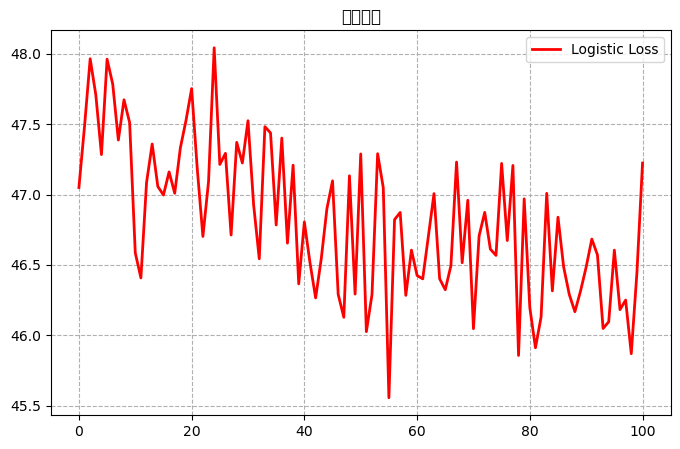

/tmp/ipykernel_19002/2313943418.py:568: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:569: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.8958, device='cuda:0')
acc_test_each_k: tensor(0.8958, device='cuda:0')
549 117
549 117
total_train_accuracy: tensor(0.8375, device='cuda:0')
Training Epoch: 0, total loss: 47.120903


/tmp/ipykernel_19002/2313943418.py:518: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:519: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.8625, device='cuda:0')
Training Epoch: 1, total loss: 46.490200
total_train_accuracy: tensor(0.8333, device='cuda:0')
Training Epoch: 2, total loss: 46.876753
total_train_accuracy: tensor(0.8625, device='cuda:0')
Training Epoch: 3, total loss: 46.428392
total_train_accuracy: tensor(0.8458, device='cuda:0')
Training Epoch: 4, total loss: 46.368402
total_train_accuracy: tensor(0.8229, device='cuda:0')
Training Epoch: 5, total loss: 46.989190
total_train_accuracy: tensor(0.8542, device='cuda:0')
Training Epoch: 6, total loss: 46.333363
total_train_accuracy: tensor(0.8271, device='cuda:0')
Training Epoch: 7, total loss: 47.190168
total_train_accuracy: tensor(0.8500, device='cuda:0')
Training Epoch: 8, total loss: 46.464159
total_train_accuracy: tensor(0.8521, device='cuda:0')
Training Epoch: 9, total loss: 46.544001
total_train_accuracy: tensor(0.8583, device='cuda:0')
Training Epoch: 10, total loss: 46.232333
total_train_accuracy: tensor(0.8563, device='cuda

total_train_accuracy: tensor(0.8563, device='cuda:0')
Training Epoch: 87, total loss: 46.084897
total_train_accuracy: tensor(0.8854, device='cuda:0')
Training Epoch: 88, total loss: 45.507556
total_train_accuracy: tensor(0.8875, device='cuda:0')
Training Epoch: 89, total loss: 45.460186
total_train_accuracy: tensor(0.8813, device='cuda:0')
Training Epoch: 90, total loss: 45.591376
total_train_accuracy: tensor(0.8583, device='cuda:0')
Training Epoch: 91, total loss: 46.120864
total_train_accuracy: tensor(0.8708, device='cuda:0')
Training Epoch: 92, total loss: 45.838574
total_train_accuracy: tensor(0.8521, device='cuda:0')
Training Epoch: 93, total loss: 46.193258
total_train_accuracy: tensor(0.8708, device='cuda:0')
Training Epoch: 94, total loss: 45.675374
total_train_accuracy: tensor(0.8854, device='cuda:0')
Training Epoch: 95, total loss: 45.357453
total_train_accuracy: tensor(0.8583, device='cuda:0')
Training Epoch: 96, total loss: 46.150020
total_train_accuracy: tensor(0.8688, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOG

total_train_accuracy: tensor(0.8729, device='cuda:0')
Training Epoch: 100, total loss: 45.775948
the  4  epoch ends


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

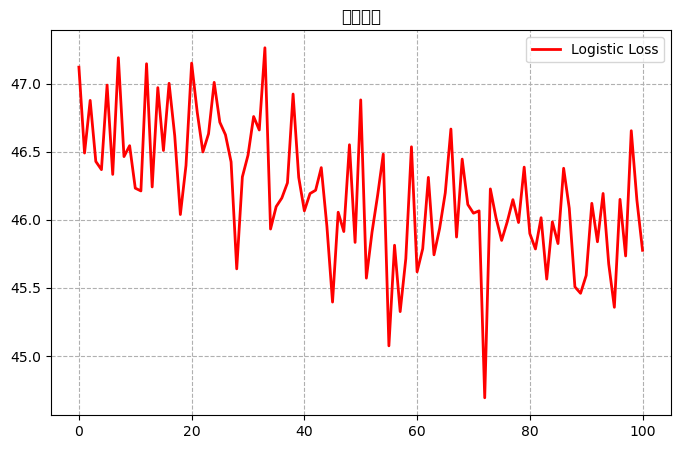

/tmp/ipykernel_19002/2313943418.py:568: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:569: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.9583, device='cuda:0')
acc_test_each_k: tensor(0.9583, device='cuda:0')
549 117
549 117
total_train_accuracy: tensor(0.8604, device='cuda:0')
Training Epoch: 0, total loss: 45.993674


/tmp/ipykernel_19002/2313943418.py:518: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:519: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.8396, device='cuda:0')
Training Epoch: 1, total loss: 46.502940
total_train_accuracy: tensor(0.8354, device='cuda:0')
Training Epoch: 2, total loss: 46.748087
total_train_accuracy: tensor(0.8750, device='cuda:0')
Training Epoch: 3, total loss: 45.856984
total_train_accuracy: tensor(0.8396, device='cuda:0')
Training Epoch: 4, total loss: 46.670649
total_train_accuracy: tensor(0.8771, device='cuda:0')
Training Epoch: 5, total loss: 45.850921
total_train_accuracy: tensor(0.8563, device='cuda:0')
Training Epoch: 6, total loss: 46.400316
total_train_accuracy: tensor(0.8563, device='cuda:0')
Training Epoch: 7, total loss: 46.407347
total_train_accuracy: tensor(0.8458, device='cuda:0')
Training Epoch: 8, total loss: 46.250620
total_train_accuracy: tensor(0.8833, device='cuda:0')
Training Epoch: 9, total loss: 45.892313
total_train_accuracy: tensor(0.8604, device='cuda:0')
Training Epoch: 10, total loss: 46.286515
total_train_accuracy: tensor(0.8500, device='cuda

total_train_accuracy: tensor(0.8771, device='cuda:0')
Training Epoch: 87, total loss: 45.515011
total_train_accuracy: tensor(0.8583, device='cuda:0')
Training Epoch: 88, total loss: 46.237727
total_train_accuracy: tensor(0.8646, device='cuda:0')
Training Epoch: 89, total loss: 45.820781
total_train_accuracy: tensor(0.8708, device='cuda:0')
Training Epoch: 90, total loss: 45.904928
total_train_accuracy: tensor(0.8813, device='cuda:0')
Training Epoch: 91, total loss: 45.591022
total_train_accuracy: tensor(0.8625, device='cuda:0')
Training Epoch: 92, total loss: 45.791599
total_train_accuracy: tensor(0.8521, device='cuda:0')
Training Epoch: 93, total loss: 46.058684
total_train_accuracy: tensor(0.8750, device='cuda:0')
Training Epoch: 94, total loss: 45.643560
total_train_accuracy: tensor(0.8479, device='cuda:0')
Training Epoch: 95, total loss: 46.668354
total_train_accuracy: tensor(0.8729, device='cuda:0')
Training Epoch: 96, total loss: 45.528531
total_train_accuracy: tensor(0.8542, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

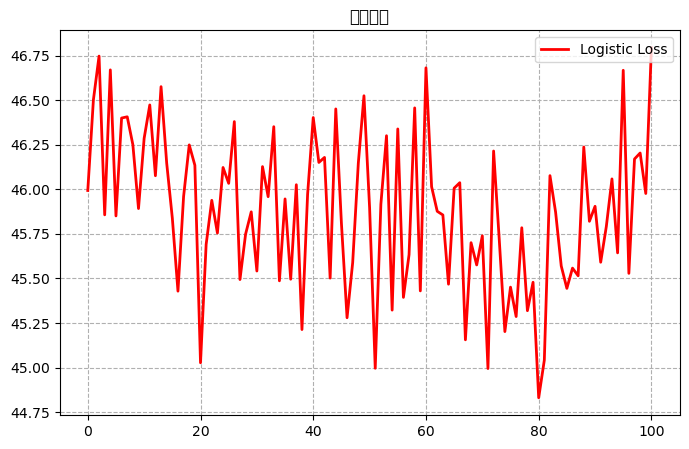

/tmp/ipykernel_19002/2313943418.py:568: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:569: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 117
549 117
total_train_accuracy: tensor(0.8854, device='cuda:0')
Training Epoch: 0, total loss: 45.323248


/tmp/ipykernel_19002/2313943418.py:518: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:519: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.8667, device='cuda:0')
Training Epoch: 1, total loss: 45.709970
total_train_accuracy: tensor(0.8583, device='cuda:0')
Training Epoch: 2, total loss: 46.003326
total_train_accuracy: tensor(0.8667, device='cuda:0')
Training Epoch: 3, total loss: 45.866887
total_train_accuracy: tensor(0.8938, device='cuda:0')
Training Epoch: 4, total loss: 45.269488
total_train_accuracy: tensor(0.8875, device='cuda:0')
Training Epoch: 5, total loss: 45.083804
total_train_accuracy: tensor(0.8646, device='cuda:0')
Training Epoch: 6, total loss: 45.838464
total_train_accuracy: tensor(0.8771, device='cuda:0')
Training Epoch: 7, total loss: 45.682490
total_train_accuracy: tensor(0.8417, device='cuda:0')
Training Epoch: 8, total loss: 46.342221
total_train_accuracy: tensor(0.8563, device='cuda:0')
Training Epoch: 9, total loss: 46.180902
total_train_accuracy: tensor(0.8917, device='cuda:0')
Training Epoch: 10, total loss: 45.250436
total_train_accuracy: tensor(0.8354, device='cuda

total_train_accuracy: tensor(0.8875, device='cuda:0')
Training Epoch: 87, total loss: 45.517312
total_train_accuracy: tensor(0.8729, device='cuda:0')
Training Epoch: 88, total loss: 45.566292
total_train_accuracy: tensor(0.8542, device='cuda:0')
Training Epoch: 89, total loss: 46.484554
total_train_accuracy: tensor(0.8625, device='cuda:0')
Training Epoch: 90, total loss: 45.856920
total_train_accuracy: tensor(0.8813, device='cuda:0')
Training Epoch: 91, total loss: 45.291238
total_train_accuracy: tensor(0.8625, device='cuda:0')
Training Epoch: 92, total loss: 46.066315
total_train_accuracy: tensor(0.8563, device='cuda:0')
Training Epoch: 93, total loss: 46.302364
total_train_accuracy: tensor(0.8792, device='cuda:0')
Training Epoch: 94, total loss: 45.288150
total_train_accuracy: tensor(0.9000, device='cuda:0')
Training Epoch: 95, total loss: 44.902321
total_train_accuracy: tensor(0.8979, device='cuda:0')
Training Epoch: 96, total loss: 44.946222
total_train_accuracy: tensor(0.8979, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

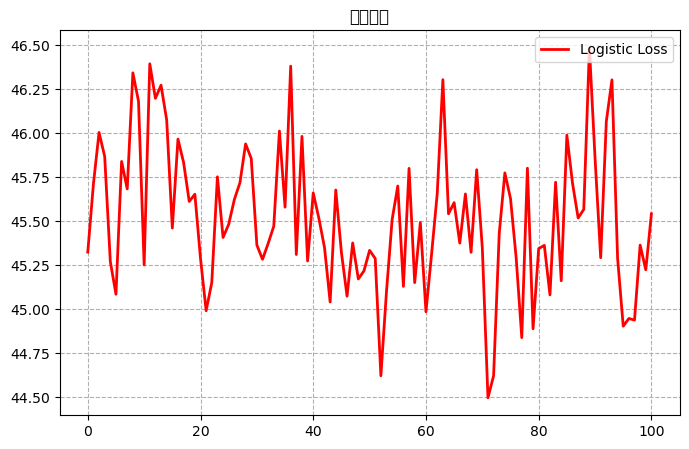

/tmp/ipykernel_19002/2313943418.py:568: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:569: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 117
549 117


/tmp/ipykernel_19002/2313943418.py:518: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:519: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.8750, device='cuda:0')
Training Epoch: 0, total loss: 45.412351
total_train_accuracy: tensor(0.8771, device='cuda:0')
Training Epoch: 1, total loss: 45.658581
total_train_accuracy: tensor(0.8688, device='cuda:0')
Training Epoch: 2, total loss: 45.556235
total_train_accuracy: tensor(0.8771, device='cuda:0')
Training Epoch: 3, total loss: 45.385621
total_train_accuracy: tensor(0.8583, device='cuda:0')
Training Epoch: 4, total loss: 45.658245
total_train_accuracy: tensor(0.8750, device='cuda:0')
Training Epoch: 5, total loss: 45.476244
total_train_accuracy: tensor(0.9083, device='cuda:0')
Training Epoch: 6, total loss: 44.695189
total_train_accuracy: tensor(0.9000, device='cuda:0')
Training Epoch: 7, total loss: 44.811401
total_train_accuracy: tensor(0.9083, device='cuda:0')
Training Epoch: 8, total loss: 44.659699
total_train_accuracy: tensor(0.8979, device='cuda:0')
Training Epoch: 9, total loss: 45.115145
total_train_accuracy: tensor(0.8792, device='cuda:

total_train_accuracy: tensor(0.8771, device='cuda:0')
Training Epoch: 87, total loss: 45.510197
total_train_accuracy: tensor(0.8875, device='cuda:0')
Training Epoch: 88, total loss: 45.421162
total_train_accuracy: tensor(0.8813, device='cuda:0')
Training Epoch: 89, total loss: 45.358364
total_train_accuracy: tensor(0.8521, device='cuda:0')
Training Epoch: 90, total loss: 46.087675
total_train_accuracy: tensor(0.8833, device='cuda:0')
Training Epoch: 91, total loss: 45.565399
total_train_accuracy: tensor(0.8875, device='cuda:0')
Training Epoch: 92, total loss: 45.310407
total_train_accuracy: tensor(0.9063, device='cuda:0')
Training Epoch: 93, total loss: 44.261754
total_train_accuracy: tensor(0.9021, device='cuda:0')
Training Epoch: 94, total loss: 45.007127
total_train_accuracy: tensor(0.8667, device='cuda:0')
Training Epoch: 95, total loss: 45.579846
total_train_accuracy: tensor(0.9083, device='cuda:0')
Training Epoch: 96, total loss: 44.332101
total_train_accuracy: tensor(0.8396, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/

the  7  epoch ends


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

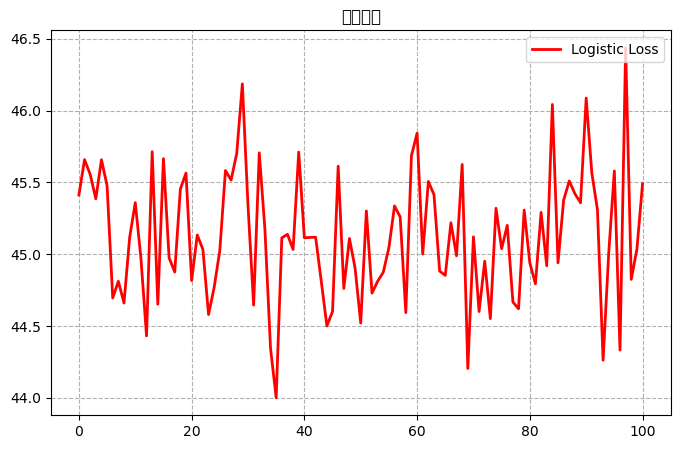

/tmp/ipykernel_19002/2313943418.py:568: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:569: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(1., device='cuda:0')
acc_test_each_k: tensor(1., device='cuda:0')
549 117
549 117
total_train_accuracy: tensor(0.8688, device='cuda:0')
Training Epoch: 0, total loss: 45.553624


/tmp/ipykernel_19002/2313943418.py:518: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:519: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.8917, device='cuda:0')
Training Epoch: 1, total loss: 44.881806
total_train_accuracy: tensor(0.8542, device='cuda:0')
Training Epoch: 2, total loss: 46.249357
total_train_accuracy: tensor(0.9042, device='cuda:0')
Training Epoch: 3, total loss: 44.913891
total_train_accuracy: tensor(0.8854, device='cuda:0')
Training Epoch: 4, total loss: 44.964905
total_train_accuracy: tensor(0.8729, device='cuda:0')
Training Epoch: 5, total loss: 45.547468
total_train_accuracy: tensor(0.8938, device='cuda:0')
Training Epoch: 6, total loss: 44.757240
total_train_accuracy: tensor(0.9083, device='cuda:0')
Training Epoch: 7, total loss: 44.576122
total_train_accuracy: tensor(0.8958, device='cuda:0')
Training Epoch: 8, total loss: 44.856955
total_train_accuracy: tensor(0.8813, device='cuda:0')
Training Epoch: 9, total loss: 45.172867
total_train_accuracy: tensor(0.8792, device='cuda:0')
Training Epoch: 10, total loss: 45.594153
total_train_accuracy: tensor(0.8771, device='cuda

total_train_accuracy: tensor(0.9229, device='cuda:0')
Training Epoch: 87, total loss: 44.274330
total_train_accuracy: tensor(0.8667, device='cuda:0')
Training Epoch: 88, total loss: 45.415088
total_train_accuracy: tensor(0.9146, device='cuda:0')
Training Epoch: 89, total loss: 44.335923
total_train_accuracy: tensor(0.8854, device='cuda:0')
Training Epoch: 90, total loss: 45.304847
total_train_accuracy: tensor(0.9042, device='cuda:0')
Training Epoch: 91, total loss: 44.828189
total_train_accuracy: tensor(0.9042, device='cuda:0')
Training Epoch: 92, total loss: 44.807696
total_train_accuracy: tensor(0.9063, device='cuda:0')
Training Epoch: 93, total loss: 44.530363
total_train_accuracy: tensor(0.8896, device='cuda:0')
Training Epoch: 94, total loss: 45.122720
total_train_accuracy: tensor(0.8958, device='cuda:0')
Training Epoch: 95, total loss: 44.934085
total_train_accuracy: tensor(0.8917, device='cuda:0')
Training Epoch: 96, total loss: 45.263579
total_train_accuracy: tensor(0.8958, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOG

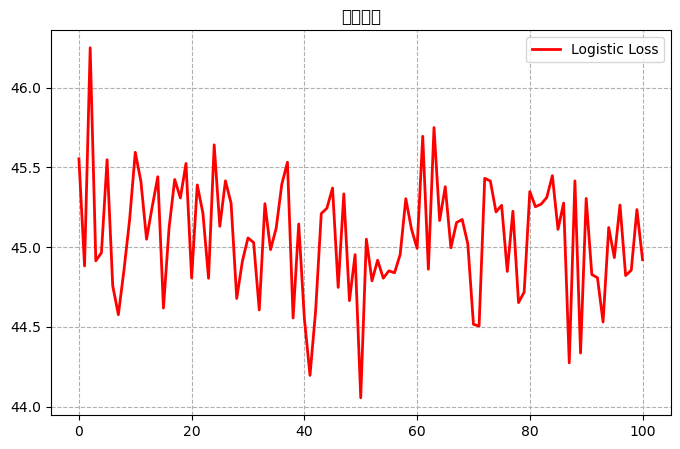

/tmp/ipykernel_19002/2313943418.py:568: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:569: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


test
test
test
total_test_accuracy: tensor(0.9792, device='cuda:0')
acc_test_each_k: tensor(0.9792, device='cuda:0')
549 117
549 117
total_train_accuracy: tensor(0.8688, device='cuda:0')
Training Epoch: 0, total loss: 45.742034


/tmp/ipykernel_19002/2313943418.py:518: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(x,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:519: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels=torch.tensor(labels,dtype=torch.float)


total_train_accuracy: tensor(0.9021, device='cuda:0')
Training Epoch: 1, total loss: 44.614279
total_train_accuracy: tensor(0.8750, device='cuda:0')
Training Epoch: 2, total loss: 45.281537
total_train_accuracy: tensor(0.8521, device='cuda:0')
Training Epoch: 3, total loss: 45.872518
total_train_accuracy: tensor(0.8896, device='cuda:0')
Training Epoch: 4, total loss: 45.175487
total_train_accuracy: tensor(0.9021, device='cuda:0')
Training Epoch: 5, total loss: 44.868360
total_train_accuracy: tensor(0.8854, device='cuda:0')
Training Epoch: 6, total loss: 45.299961
total_train_accuracy: tensor(0.8646, device='cuda:0')
Training Epoch: 7, total loss: 45.593724
total_train_accuracy: tensor(0.8938, device='cuda:0')
Training Epoch: 8, total loss: 45.086635
total_train_accuracy: tensor(0.9042, device='cuda:0')
Training Epoch: 9, total loss: 44.611941
total_train_accuracy: tensor(0.9083, device='cuda:0')
Training Epoch: 10, total loss: 44.535790
total_train_accuracy: tensor(0.8958, device='cuda

total_train_accuracy: tensor(0.9104, device='cuda:0')
Training Epoch: 87, total loss: 44.564649
total_train_accuracy: tensor(0.8896, device='cuda:0')
Training Epoch: 88, total loss: 44.965796
total_train_accuracy: tensor(0.9000, device='cuda:0')
Training Epoch: 89, total loss: 44.636805
total_train_accuracy: tensor(0.8917, device='cuda:0')
Training Epoch: 90, total loss: 44.902139
total_train_accuracy: tensor(0.8958, device='cuda:0')
Training Epoch: 91, total loss: 44.928049
total_train_accuracy: tensor(0.8938, device='cuda:0')
Training Epoch: 92, total loss: 44.746666
total_train_accuracy: tensor(0.9042, device='cuda:0')
Training Epoch: 93, total loss: 44.433103
total_train_accuracy: tensor(0.9167, device='cuda:0')
Training Epoch: 94, total loss: 44.344694
total_train_accuracy: tensor(0.9063, device='cuda:0')
Training Epoch: 95, total loss: 44.400624
total_train_accuracy: tensor(0.8563, device='cuda:0')
Training Epoch: 96, total loss: 45.785412
total_train_accuracy: tensor(0.9125, dev

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/home/zhengfang/anaconda3/envs/my_pytorch_gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zhengfang/anaconda3

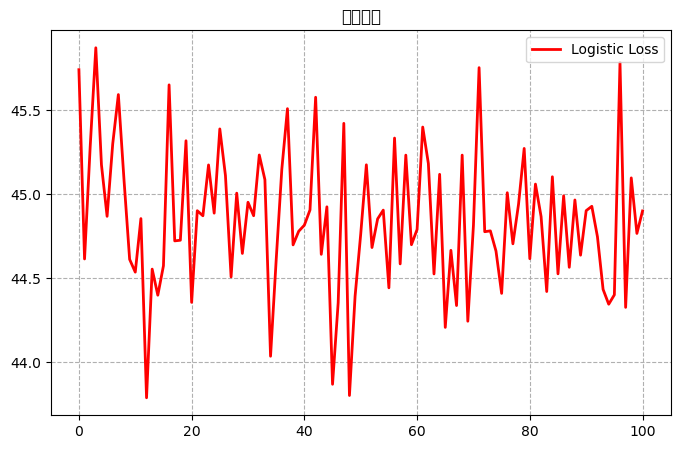

test
test
test
total_test_accuracy: tensor(0.9792, device='cuda:0')
acc_test_each_k: tensor(0.9792, device='cuda:0')
[tensor(0.6667, device='cuda:0'), tensor(0.7083, device='cuda:0'), tensor(0.8958, device='cuda:0'), tensor(0.8958, device='cuda:0'), tensor(0.9583, device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(1., device='cuda:0'), tensor(0.9792, device='cuda:0'), tensor(0.9792, device='cuda:0')]
[array(0.6666667, dtype=float32), array(0.7083334, dtype=float32), array(0.8958334, dtype=float32), array(0.8958334, dtype=float32), array(0.9583334, dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(0.9791667, dtype=float32), array(0.9791667, dtype=float32)]
acc_test_metrics: 0.9083334


/tmp/ipykernel_19002/2313943418.py:568: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs ,dtype=torch.float)
/tmp/ipykernel_19002/2313943418.py:569: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets ,dtype=torch.float)


In [6]:
model=model20
K=10
test_metrics=[]
train_loss_total_list=[]
for ki in range(K):
    trainset = KZDataset(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP_10layers_add//LRP/train_val_info_150.csv',K=K, n_class=nfm_config['n_class'],ki=ki,  typ='train', transform=None, rand=True)
    valset = KZDataset(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP_10layers_add//LRP/train_val_info_150.csv', K=K,n_class=nfm_config['n_class'],ki=ki,  typ='val', transform=None, rand=True)
    train_loader = data.DataLoader(
         dataset=trainset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size'],
         shuffle=True)
    val_loader = data.DataLoader(
         dataset=valset,
         #transform=torchvision.transforms.ToTensor(),
         drop_last=True,
         batch_size=nfm_config['batch_size']
        
     )
    
    model_path='models/ConvAttMLP_10layers_add//LRP/100'
    #BATCH_SIZE=batch_size
    optimizer = torch.optim.Adam(model.parameters(), lr=nfm_config['lr'], weight_decay=nfm_config['l2_regularization'])
    #total = 0
    
    
    loss_func=torch.nn.CrossEntropyLoss()
    
    num=0
   
    
    epoches=101
    for epoch_id in range(epoches):
          
        
        
        train_loss_total,acc_train=train_epoch(model,train_loader,nfm_config['batch_size'],optimizer,loss_func)
        train_loss_total_list.append(train_loss_total)#
        if epoch_id %20==0:
            num=num+1
            #path=os.path.join(model_path,'MLP'+str(num)+str(K)+'.pkl')
            #torch.save(model.state_dict(),path)
            # 保存模型
            
            path=os.path.join(model_path,'MLP'+str(num)+str(K)+'.pt')##################pt
            torch.save(model.state_dict(),path)
            #torch.save(model.state_dict(),path)
    print("the ",ki," epoch ends")
    plotLoss(train_loss_total_list,epoches)
    train_loss_total_list=[]
    acc_test=val_epoch(model,val_loader,nfm_config['batch_size'],optimizer)
    print("acc_test_each_k:",acc_test)
    test_metrics.append(acc_test)

print(test_metrics)
#test_metrics=test_metrics.tolist()
test_metrics=[x.cpu().detach().numpy() for x in test_metrics]
print(test_metrics)
acc_test_metrics=np.mean(test_metrics) 
print("acc_test_metrics:",acc_test_metrics)
       


MLP20(
  (bn0): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=56, out_features=2000, bias=True)
  (bn1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (bn2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=9, bias=True)
  (bn3): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)
138 57
f1_score:  %.4f 0.781316794061892
accuracy_score: 0.7971014492753623
recall_score: 0.7861407582976211
pre_recall: 0.7923909748471152
n_classes: 9


/tmp/ipykernel_26865/2262859947.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_26865/2262859947.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets=torch.tensor(targets,dtype=torch.float)
/tmp/ipykernel_26865/2262859947.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs=torch.tensor(inputs,dtype=torch.float)
/tmp/ipykernel_26865/2262859947.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or source

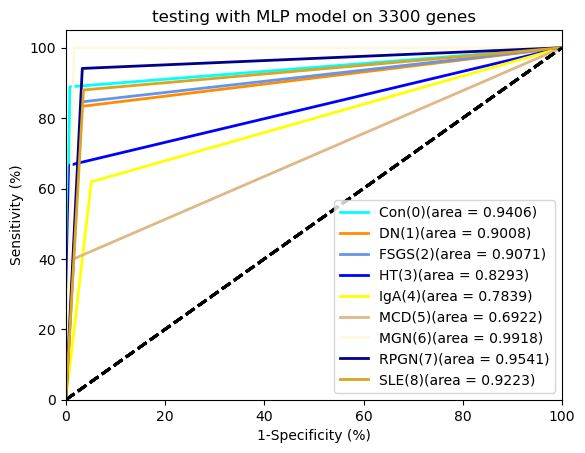

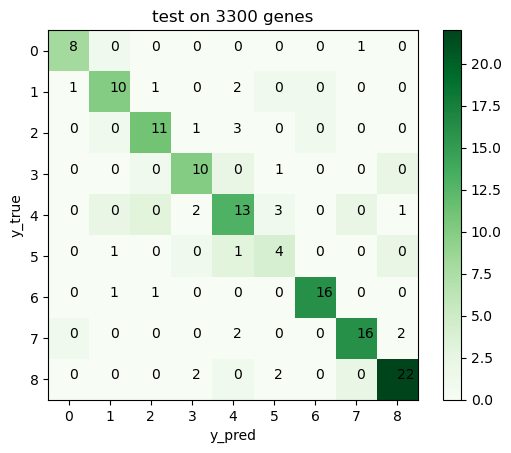

In [14]:
import torch

#功能：加载保存到path中的各层参数到神经网络

#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP610.pkl'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP9110.pkl'
path='models/ConvAttMLP_10layers_add//LRP/50/MLP610.pt'
#path='dataset/qiuguan/model_new_K_fold_RandomTree/MLP_non_encode/MLP10910.pkl'
#nfm=NFM(nfm_config)
#mlp=MLP()
mlp=MLP20()
#print(nfm)
#net = nn.DataParallel(net)
#net = net.to(device)
mlp.load_state_dict(torch.load(path),strict=False)
mlp.cuda()

print(mlp)




mlp_params = list(mlp.named_parameters())
#print(nfm_params)
net=mlp


testset = KZDatasetTest(csv_path='dataset/qiuguan/origin_800/xiaoqiu_xiaoguan/ConvAttMLP_10layers_add//LRP/test_info_30.csv')
   
test_loader = data.DataLoader(
         dataset=testset,
         #transform=torchvision.transforms.ToTensor(),
         
         batch_size=nfm_config['batch_size']
        
     )
#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/121708431# 
from torch.autograd import Variable 
from torch.utils.data import DataLoader 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import accuracy_score 
 
def evaluate_model(test_dl, model): 
    model.eval()#测试数据稳定
    predictions, actuals = [], [] 
    for i, (inputs, targets) in enumerate(test_dl): 
        # evaluate the model on the test set 
        #print(\ inputs:\ ,inputs) 
        #print(\ targets:\ ,targets) 
        inputs = Variable(inputs) 
        targets = Variable(targets) 
                 
                 
        #x = torch.tensor(x, dtype=torch.float) 
        #x=x.clone().detach().requires_grad_(True) 
        inputs=torch.tensor(inputs,dtype=torch.float) 
        targets=torch.tensor(targets,dtype=torch.float) 
        inputs, targets = inputs.cuda(), targets.cuda() 
        yhat = model(inputs) 
        yhat=(yhat==torch.max(yhat,1,keepdim=True)[0]).to(dtype=torch.int32)
        # retrieve numpy array 
        #yhat = yhat.detach().numpy() 
        yhat = yhat.detach().cpu().numpy()#转换到cpu 
        # yhat=yhat.argmax(axis=1) 
        #print(yhat:\ ,yhat) 
        #print('yhat.shape:',yhat.shape) 
        actual = targets.detach().cpu().numpy() 
        actual=actual.round() 
        #print(\ actual:\ ,actual) 
        #print('actual.shape:',actual.shape
        #predictions.appe) 
        #actual = actual.reshape(-1, 1) 
        # round to class values 
        yhat = yhat.round() 
        # store nd(yhat) 
        actuals.append(actual) 
        predictions.append(yhat)
    #print("prediction:" ,predictions) 
    #print("actuals:",actuals) 
    predictions, actuals = np.vstack(predictions), np.vstack(actuals) 
    #print("prediction:" ,predictions) 
    #print("actuals:" ,actuals) 
    # calculate accuracy 
    acc_test = accuracy_score(actuals, predictions) 
    return  actuals, predictions,acc_test 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 
from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 

import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


import torch.nn.functional as F 

actuals,predictions,acc_test=evaluate_model(test_loader,net)


from sklearn.metrics import precision_recall_curve, average_precision_score,roc_curve, auc, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score 
target_list=actuals 
pred_list=predictions 
      
y_true=target_list 
y_pred=pred_list 
      
f1=f1_score(y_true=target_list, y_pred=pred_list, average='macro') # 也可以指定micro模式 
acc_score=accuracy_score(y_true=target_list, y_pred=pred_list) 
rec_score=recall_score(y_true=target_list,y_pred=pred_list,average='macro') # 也可以指定micro模式 
pre_recall=precision_score(y_true=target_list,y_pred=pred_list,average='macro') 
print("f1_score:  %.4f" ,f1) 
print("accuracy_score:" ,acc_score) 
print("recall_score:",rec_score) 
print("pre_recall:" ,pre_recall)



auc_curve = roc_auc_score(y_true, y_pred, multi_class='ovo')
#———————————————— 
#版权声明：本文为CSDN博主「农民小飞侠」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/w5688414/article/details/106595892 
PM_y=y_pred 
true_y=y_true 
n_classes=PM_y.shape[1] 
      
print("n_classes:",n_classes) 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
for i in range(n_classes): 
    fpr[i], tpr[i], _ = roc_curve(true_y[:, i], PM_y[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
    #print(i) 
    #print(fpr) 
    #print(tpr) 
    
    
    
#计算macro auc 
from scipy import interp 
# First aggregate all false positive rates 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)])) 
       
# Then interpolate all ROC curves at this points 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(n_classes): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
       
    # Finally average it and compute AUC 
    mean_tpr /= n_classes 
       
    fpr["macro"] = all_fpr 
    tpr["macro"] = mean_tpr 
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    
    
#画图 
      
import matplotlib.pyplot as plt 
from itertools import cycle 
from matplotlib.ticker import FuncFormatter 
lw = 2 
# Plot all ROC curves 
plt.figure() 
labels=['Con(0)','DN(1)','FSGS(2)','HT(3)','IgA(4)','MCD(5)','MGN(6)','RPGN(7)','SLE(8)'] 

'''
plt.plot(fpr["macro"], tpr["macro"], 
              label='macro-average ROC curve (area = {0:0.4f})' 
                    ''.format(roc_auc["macro"]), 
              color='navy', linestyle=':', linewidth=4) 
'''

       
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','blue','yellow','burlywood','cornsilk','darkblue','goldenrod','greenyellow','maroon']) 
for i, color in zip(range(n_classes), colors): 
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                  label=labels[i]+'(area = {0:0.4f})'.format(roc_auc[i])) 
       
    plt.plot([0, 1], [0, 1], 'k--', lw=lw) 
    plt.xlim([0.0, 1.0]) 
    plt.ylim([0.0, 1.05]) 
      
      
    plt.xlabel('1-Specificity (%)') 
    plt.ylabel('Sensitivity (%)') 
    #plt.title('testing on kidney tubules with F800 without augment') 
    plt.title('testing with MLP model on 3300 genes')   

        
def to_percent(temp, position): 
    return '%1.0f'%(100*temp) 
      
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.gca().xaxis.set_major_formatter(FuncFormatter(to_percent)) 
plt.legend(loc="lower right" ) 
      
plt.show() 

#———————————————— 
#版权声明：本文为CSDN博主「山阴少年」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。 
#原文链接：https://blog.csdn.net/jclian91/article/details/103074506/ 
      
from sklearn.metrics import confusion_matrix 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
      
# 支持中文字体显示, 使用于Mac系统 
#zhfont=mpl.font_manager.FontProperties(fname=\ /Library/Fonts/Songti.ttc\ ) 
      
y_true=actuals# = ['北京', '上海', '成都', '成都', '上海', '北京', '上海', '成都', '北京', '上海'] 
y_pred=predictions #= ['北京', '上海', '成都', '上海', '成都', '成都', '上海', '成都', '北京', '上海'] 
      
#ValueError: multilabel-indicator is not supported 
      
classes = [0,1,2,3,4,5,6,7,8] 
#confusion = confusion_matrix(y_true, y_pred)#ValueError: multilabel-indicator is not supported 
      
confusion = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)) 
# 绘制热度图 
plt.imshow(confusion, cmap=plt.cm.Greens) 
indices = range(len(confusion)) 
#plt.xticks(indices, classes, fontproperties=zhfont) 
#plt.yticks(indices, classes, fontproperties=zhfont) 
      
plt.xticks(indices, classes) 
plt.yticks(indices, classes) 
plt.colorbar() 
plt.xlabel('y_pred') 
plt.ylabel('y_true') 
plt.title('test on 3300 genes')      
# 显示数据 
for first_index in range(len(confusion)): 
    for second_index in range(len(confusion[first_index])): 
        plt.text(first_index, second_index, confusion[first_index][second_index]) 
      
# 显示图片 
plt.show()